In [1]:
__author__ = 'Derek Qi'
# Doing portfolio backtest and generates output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time
import pickle
import os
import sklearn.preprocessing as pp

from setup.univ_setup import *
from factor_mining.combine_factors import *
from factor_mining.factor_model_regression import *
from factor_mining.factor_preprocessing import *

from factor_model.stock_ret_est import GenReturn 
from GenPosition import *
from backtest_main import *

from factor_mining.factors.momentum import *

from factor_mining.Mark0 import * # This is alpha file

In [19]:
def backtest_single_period(univ, factor_exp_mat, ret_series, t, silent=True):
    '''
    Do a single period backtest on univ[t]
    t: datetime object that is one of the element in keys of univ
    factor_exp_mat, ret_series: factor exposure and return time series
    '''
    # Set backtest params
    lookback = timedelta(weeks=104)
    dend = t
    dstart = dend - lookback

    # Calc stock return
    # ret_series = momentum(univ, 0, 1)

    # Fit single period factor return
    fr, fr_mse = factor_model_fit(factor_exp_mat, ret_series, dstart, dend)

    fx = factor_exp_mat[dend]
    fx = fx.dropna()
    # Filt the available pool
    univ_fin = univ[dend]
    univ_fin = univ_fin.dropna()
    # Throw away penny stocks
    univ_fin = filt_byval_single_period(univ_fin, 'price', 10)
    # Throw away illiquid stocks
    univ_fin = filt_byval_single_period(univ_fin, 'volume', 1500000)
    # Throw away things in MA
    univ_fin = filt_byval_single_period(univ_fin, 'inMA', 0)
    fx = pd.merge(fx, univ_fin[['ticker']], how='inner', on='ticker')
    
    # Calculate position
    stock_list, w_opt = GenPosition(fr, fx, U=0.2)
    w_opt = PositionFilter(w_opt) # filt away very small number in portfolio
    ptfl_full = pd.DataFrame({"ticker": stock_list, "weight": list(w_opt.T[0])})
    ptfl_full = pd.merge(ptfl_full, univ_fin[['ticker', 'log_ret']], how='inner', on='ticker')
    ptfl_full.loc[ptfl_full.log_ret < -1, 'log_ret'] = 0 # Emergency process for stocks in MA for over 6 months
    pnl_sp = np.dot(ptfl_full.weight, ptfl_full.log_ret)

    if not silent:
        print('Pool size: %d' % univ_fin.shape[0])
        print(ptfl_full[ptfl_full['weight'] != 0])
        print('Period log pnl: %f' % pnl_sp)
    
    # fx.to_csv('./temp/factor_exposure_' + t.strftime('%Y%m%d') + '.csv', index=False)
    # fr.to_csv('./temp/factor_return_' + t.strftime('%Y%m%d') + '.csv', index=False)
    return ptfl_full, pnl_sp


def backtest_batch(univ, factor_exp_mat, ret_series, dstart, dend, silent=True):
    '''
    Run backtest in batch to portfolio from dstart to dend
    '''
    datelst = sorted(univ.keys())
    tin_lst, ptfl_lst, pnl_lst = [], [], []
    for ti in range(len(datelst)):
        t = datelst[ti]
        
        if t < dstart or t > dend:
            continue

        if not silent:
            print(t)

        tin_lst.append(t)
        ptfl, pnl_sp = backtest_single_period(univ, factor_exp_mat, ret_series, t, silent)
        ptfl_lst.append(ptfl)
        pnl_lst.append(pnl_sp)


    pnl = pd.DataFrame({'date': tin_lst, 'pnl': pnl_lst})
    return ptfl_lst[-1], pnl

def backtest_multi_period_rebalance(univ, factor_exp_mat, ret_series, dstart, dend, rebalance, silent=True):
    '''
    Backtest with multi-period rebalancing
    '''
    datelst = sorted(univ.keys())
    tin_lst, ptfl_lst, pnl_lst = [], [], []
    count = 0
    for ti in range(len(datelst)):
        t = datelst[ti]
        
        if t < dstart or t > dend:
            continue
        
        if not silent:
            print(t)
        
        tin_lst.append(t)
        
        if count == 0:
            # Do rebalance
            ptfl, pnl_sp = backtest_single_period(univ, factor_exp_mat, ret_series, t, silent)
            ptfl_lst.append(ptfl)
            pnl_lst.append(pnl_sp)
        else:
            # Use prev portfolio
            ptfl = ptfl_lst[-1].copy()
            ptfl = ptfl[['ticker','weight']]
            # Filt the available pool
            univ_fin = univ[t]
            univ_fin = univ_fin.dropna()
            # Throw away penny stocks
            univ_fin = filt_byval_single_period(univ_fin, 'price', 10)
            # Throw away illiquid stocks
            univ_fin = filt_byval_single_period(univ_fin, 'volume', 1500000)
            # Throw away things in MA
            univ_fin = filt_byval_single_period(univ_fin, 'inMA', 0)
            
            # Force clear what is not in the pool now and re-normalize the weight
            ptfl = pd.merge(ptfl, univ_fin[['ticker', 'log_ret']], how='inner', on='ticker')
#             print(ptfl.head())
            ptfl.loc[ptfl.log_ret < -1, 'log_ret'] = 0 # Emergency process for stocks in MA for over 6 months
            pnl_sp = np.dot(ptfl.weight, ptfl.log_ret)
            
            ptfl_lst.append(ptfl)
            pnl_lst.append(pnl_sp)
            
            if not silent:
                print('Pool size: %d' % univ_fin.shape[0])
                print(ptfl[ptfl['weight'] != 0])
                print('Period log pnl: %f' % pnl_sp)    
        count -= 1
        count %= rebalance
        pnl = pd.DataFrame({'date': tin_lst, 'pnl': pnl_lst})
        
    return ptfl, pnl
    

In [3]:
### universe setup ###
print('Setup R3000 universe')
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
start = time()
if os.path.exists(datadir + 'univ.pkl'):
    print('use existing binary')
    with open(datadir + 'univ.pkl', 'rb') as univ_fh:
        univ = pickle.load(univ_fh)
    
else:
    print('construct from csv')
    big_table_dir = datadir + 'big_table_full_v3.csv'
    univ = univ_setup(big_table_dir)
    filt_by_name(univ) # This is fucking slow！
    with open(datadir + 'univ.pkl','wb') as fh:
        pickle.dump(univ, fh)
end = time()
print('%f seconds' % (end - start))

Setup R3000 universe
construct from csv
176.285232 seconds


In [4]:
### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_four_factors(univ)
# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
# Preprocessing factor expsure matrices
factor_exp_mat = process_batch(factor_exp_mat, pp.scale)
factor_exp_mat = process_batch(factor_exp_mat, winsorize)
print('Done')

Calculate factors


/home/derek-qi/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Done


In [5]:
# const setup
factor_names = [k for k in factors.keys()]
N_f = len(factor_names)
datelst = sorted(factor_exp_mat.keys())
N_T = len(datelst)

# Calc stock returns
ret_series = momentum(univ, 0, 1)

for k, r in ret_series.items():
    r.columns = ['date', 'ticker', 'pct_return']

In [20]:
# Run backtest
dstart = datetime(2014, 1, 1)
dend = datetime(2017, 1, 31)
print('Start backtest from %s to %s' % (dstart.strftime('%Y/%m/%d'), dend.strftime('%Y/%m/%d')))
ts = time()
# ptfl_fin, pnl = backtest_batch(univ, factor_exp_mat, ret_series, dstart, dend, silent=False)
ptfl_fin, pnl = backtest_multi_period_rebalance(univ, factor_exp_mat, ret_series, dstart, dend, 4, silent=False)
te = time()
print(te - ts)

Start backtest from 2014/01/01 to 2017/01/31
2014-01-03 00:00:00
Pool size: 610
    ticker    weight   log_ret
10    ACAD  0.200002 -0.045766
95     BZH  0.140262 -0.050601
221    FSL  0.197508 -0.000651
362   MTOR  0.139515  0.059921
423    PHM  0.024298  0.005968
448    RDN  0.200002  0.083158
506   SRPT  0.098414 -0.050676
Period log pnl: 0.003770
2014-01-10 00:00:00
Pool size: 813
    ticker    weight   log_ret
10    ACAD  0.200002 -0.003737
92     BZH  0.140262 -0.028072
212    FSL  0.197508  0.058785
348   MTOR  0.139515 -0.016076
408    PHM  0.024298 -0.040490
432    RDN  0.200002  0.013638
488   SRPT  0.098414  0.320837
Period log pnl: 0.038001
2014-01-17 00:00:00
Pool size: 789
    ticker    weight   log_ret
10    ACAD  0.200002 -0.039454
86     BZH  0.140262 -0.035314
204    FSL  0.197508 -0.066628
332   MTOR  0.139515 -0.108649
391    PHM  0.024298 -0.027227
413    RDN  0.200002 -0.045538
465   SRPT  0.098414 -0.051333
Period log pnl: -0.055983
2014-01-24 00:00:00
Pool size:

In [21]:
#output the final portfolio
outputdir = './output/'
now = datetime.now()
nowstr = now.strftime('%Y%m%d_%H:%M:%S')
pnl.to_csv('./output/pnl_series' + nowstr + '.csv')
GenPortfolioReport(ptfl_fin, report_file=outputdir + 'portfolio_report_long_only'+nowstr+'.csv', pt=True)

  ticker    weight                             Name Prev Close  \
0   ACIA  0.104342      Acacia Communications, Inc.      54.61   
1    ATW  0.029589  Atwood Oceanics, Inc. Common St       9.31   
2   CENX  0.034146         Century Aluminum Company     12.930   
3    CRC  0.200000  California Resources Corporatio      15.71   
4   FMSA  0.148903  Fairmount Santrol Holdings Inc.       7.32   
5   HALO  0.028939      Halozyme Therapeutics, Inc.      12.60   
6    JOY  0.200000                  Joy Global Inc.      28.30   
7   TMST  0.167544  Timken Steel Corporation Common      19.07   
8   XLRN  0.086536            Acceleron Pharma Inc.      27.01   

  Avg Daily Volume Market Cap PE ratio  
0          1560720      2.10B    16.96  
1          3619710    734.68M     2.51  
2          2916350      1.15B     None  
3          1637810    654.72M     2.28  
4          4863370      1.66B     None  
5          1448740      1.62B     None  
6          1049680      2.82B     None  
7          

CAGR:0.001733 
Volatility:0.032376
Sharpe_ratio:0.053491
max drawdown: -0.014211
drawdown length: 71.000000



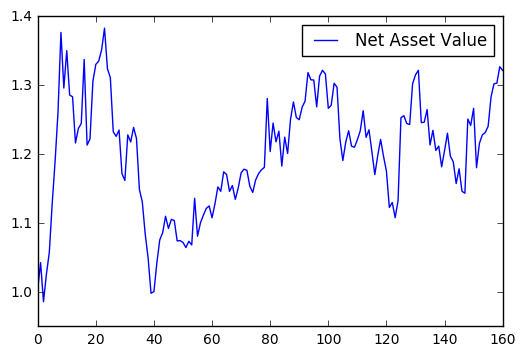

In [22]:
from performance_analysis.pa_core import *
pnl.columns = ['Date', 'Pnl']
# simple_pa(pnl)
pmfc = (cagr(pnl), vol(pnl), sharpe_ratio(pnl), max_drawdown(pnl), drawdown_length(pnl))
print('CAGR:%f \nVolatility:%f\nSharpe_ratio:%f\nmax drawdown: %f\ndrawdown length: %f\n' % pmfc)

plot_nav(pnl)